In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error

import optuna
from optuna.integration import (
    CatBoostPruningCallback,
    XGBoostPruningCallback,
    LightGBMPruningCallback
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]

## Data Quality

In [3]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_33377/596384151.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nan_counts.index, y=nan_counts.values, palette="viridis")


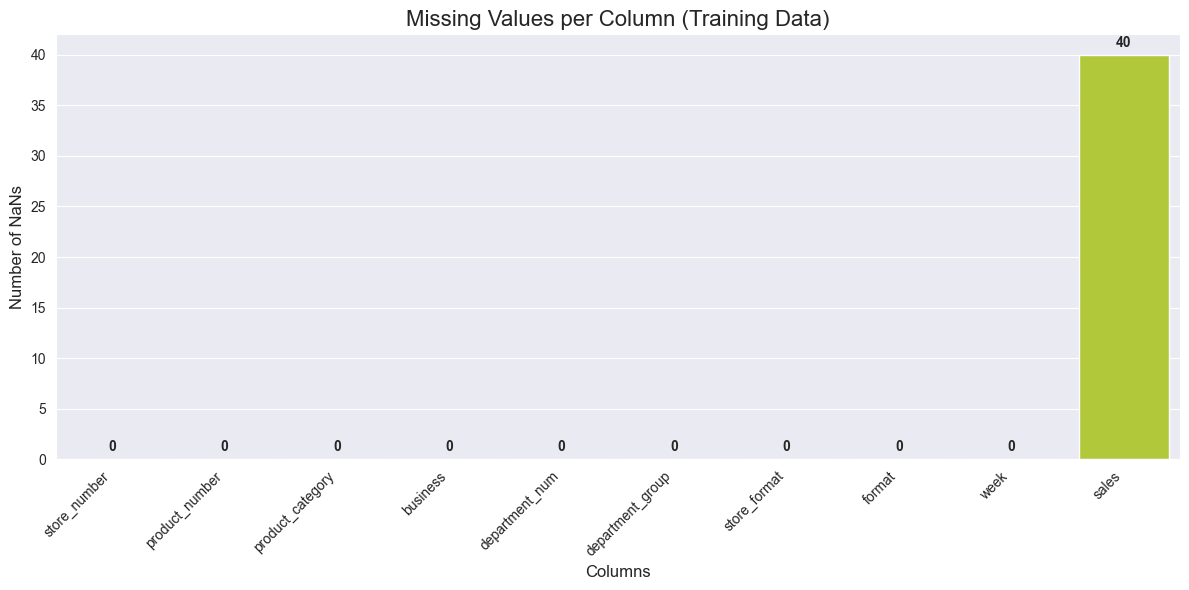

In [4]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=nan_counts.index, y=nan_counts.values, palette="viridis")

plt.title("Missing Values per Column (Training Data)", fontsize=16)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Preprocessing

In [5]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
format                       int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int32
dtype: object

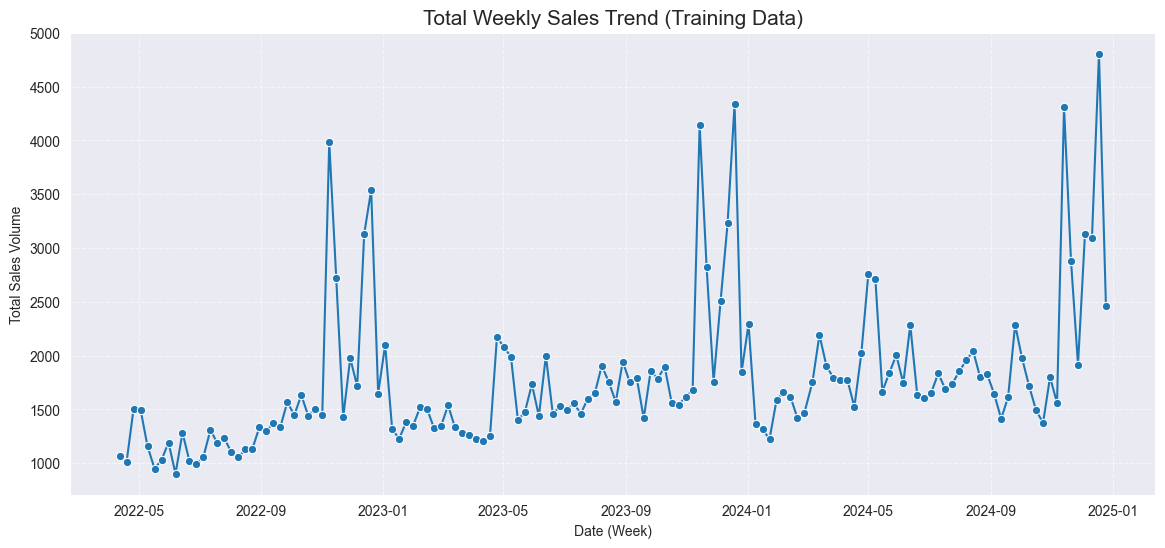

In [6]:
plt.figure(figsize=(14, 6))
weekly_sales = X_train_preprocessed.groupby('week')['sales'].sum().reset_index()
sns.lineplot(data=weekly_sales, x='week', y='sales', marker='o', color='#1f77b4')
plt.title('Total Weekly Sales Trend (Training Data)', fontsize=15)
plt.xlabel('Date (Week)')
plt.ylabel('Total Sales Volume')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_33377/175787391.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


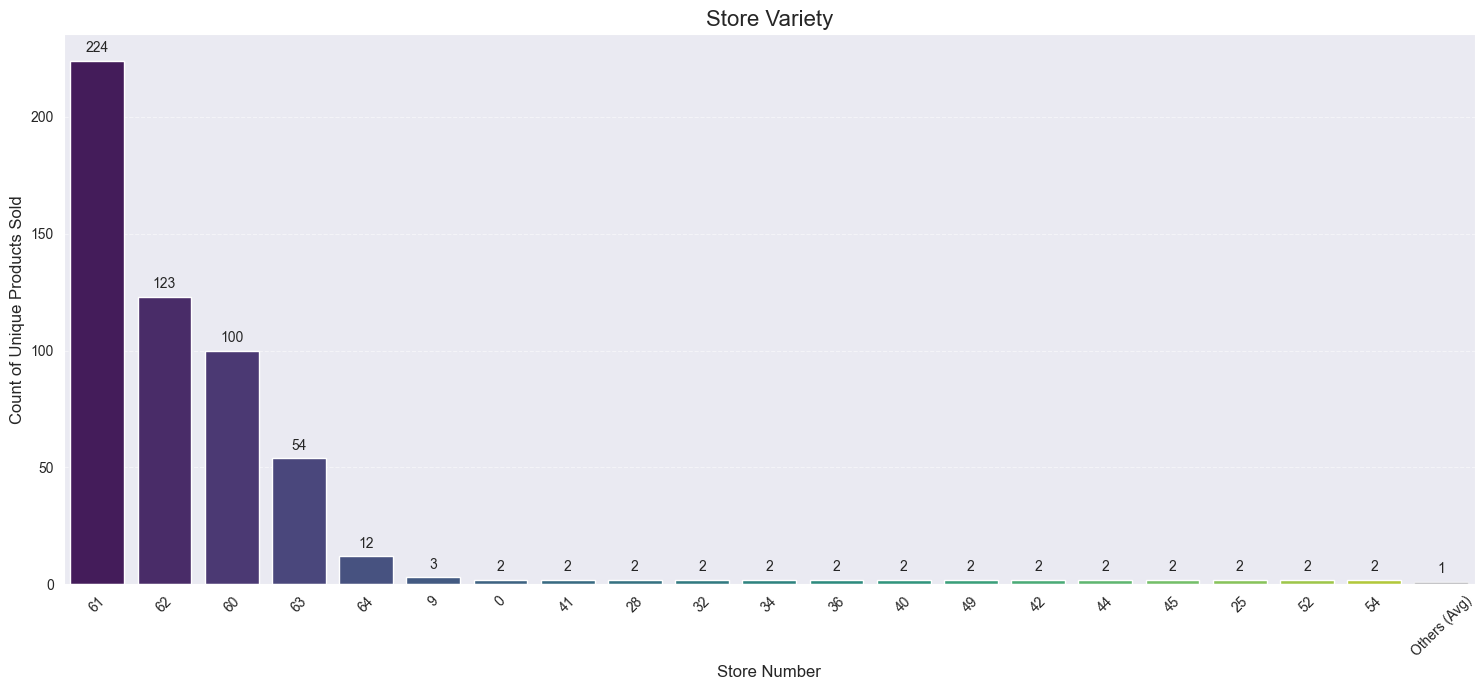

In [7]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others (Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(15, 7))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_33377/2061478277.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


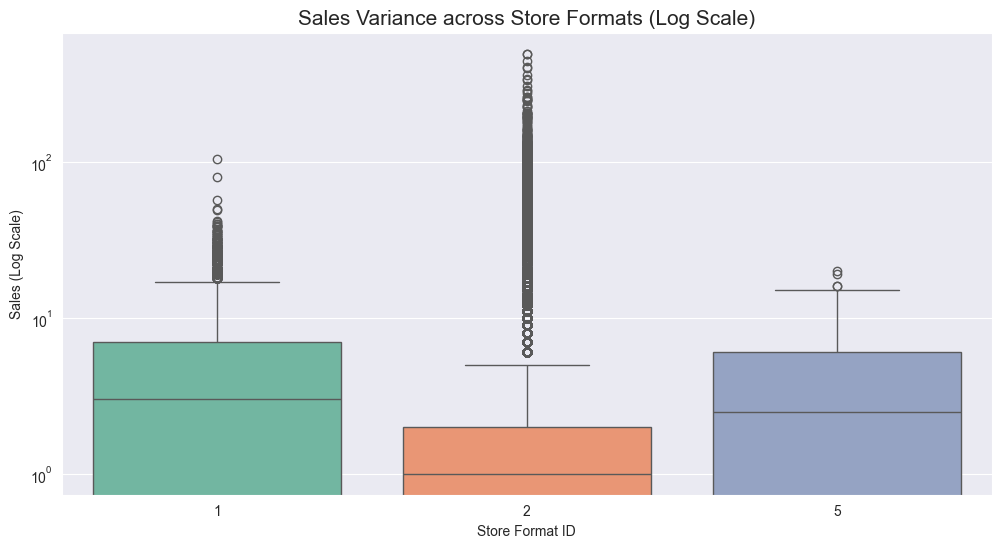

In [8]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.show()

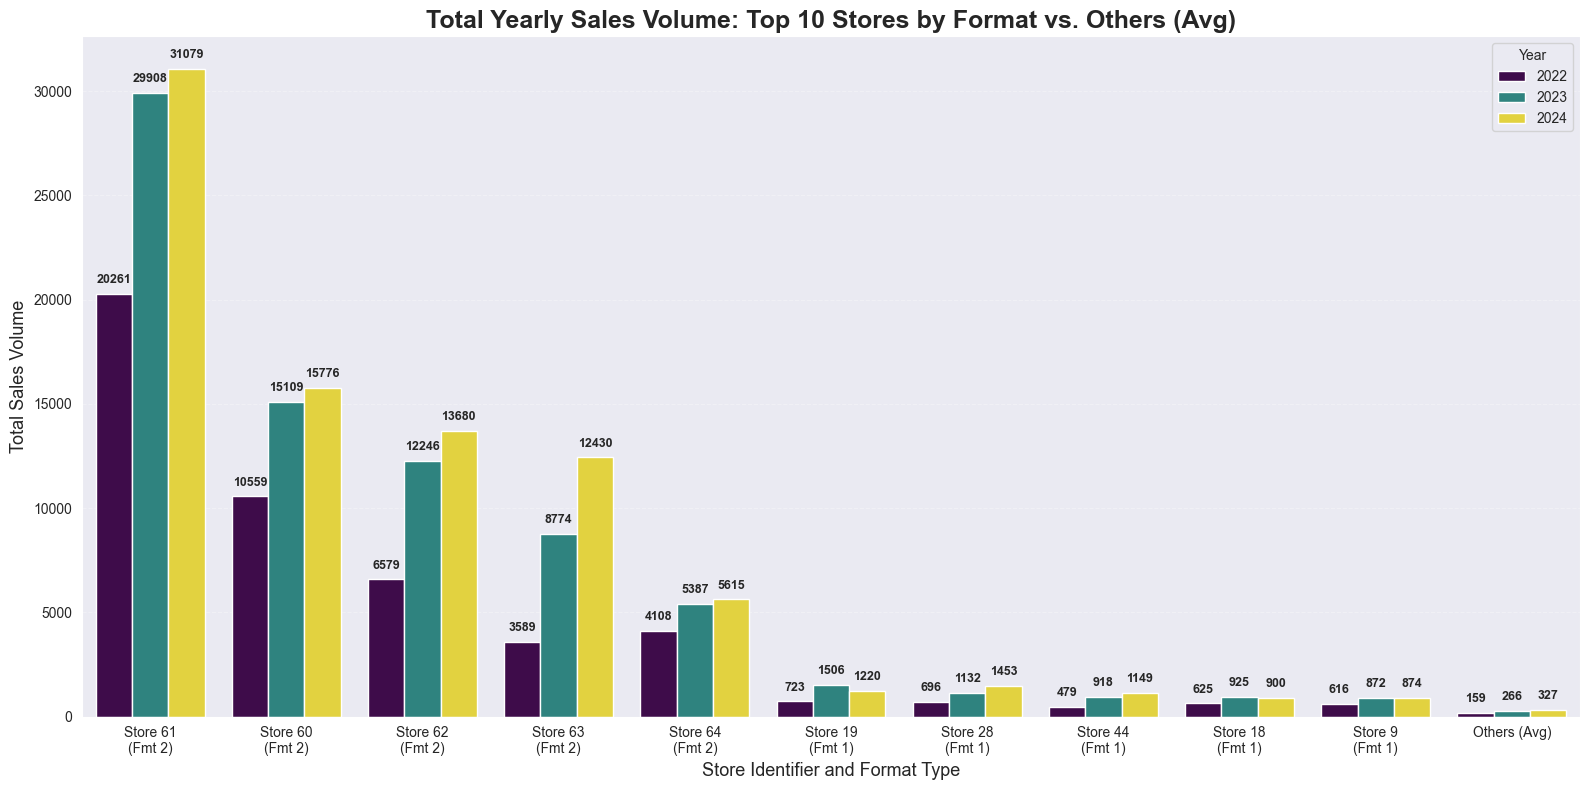

In [9]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

plt.figure(figsize=(16, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette='viridis',
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', fontsize=18, fontweight='bold')
plt.xlabel('Store Identifier and Format Type', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

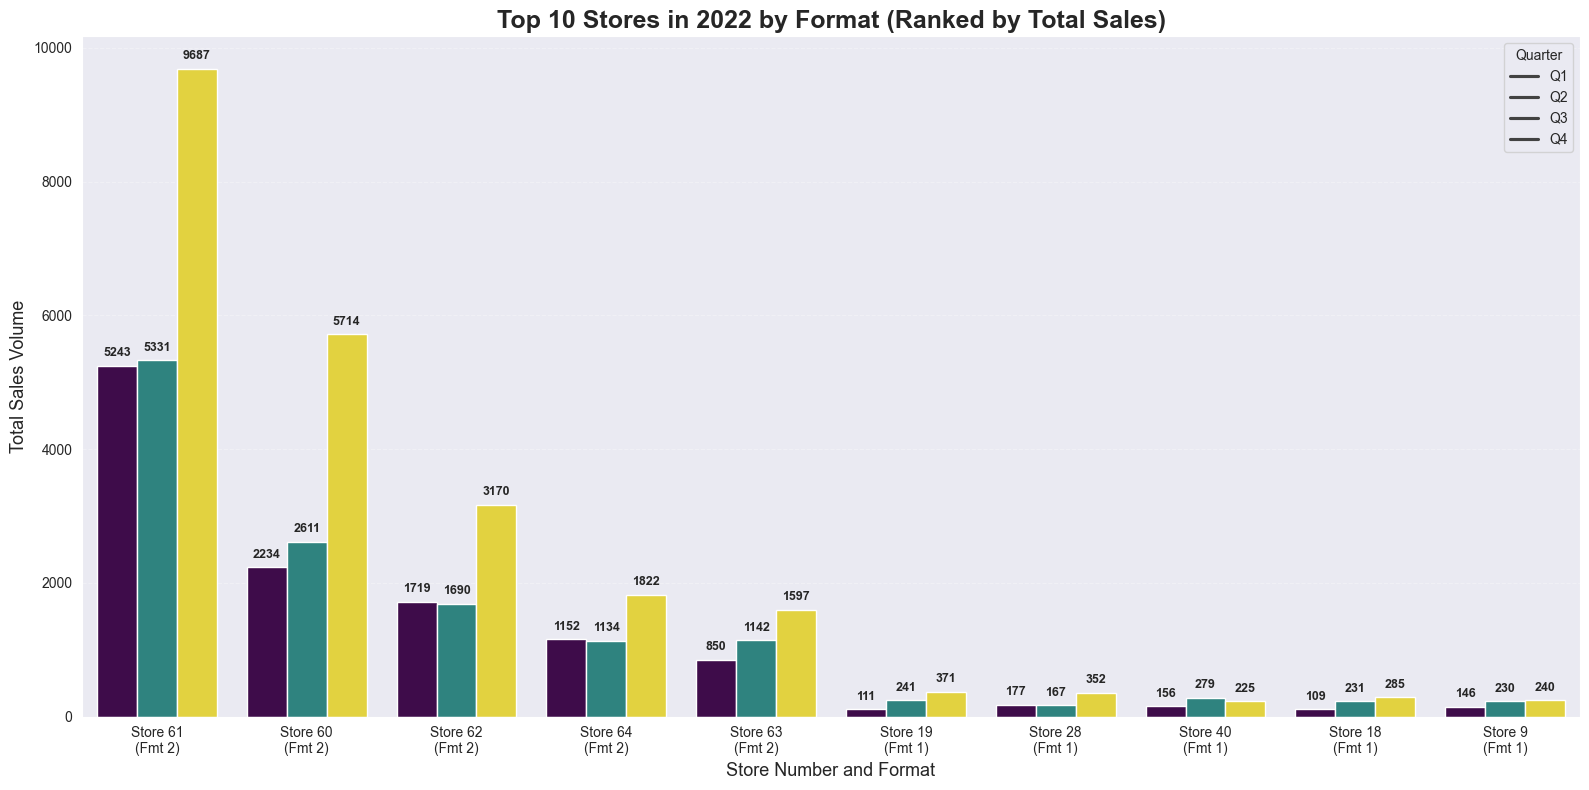

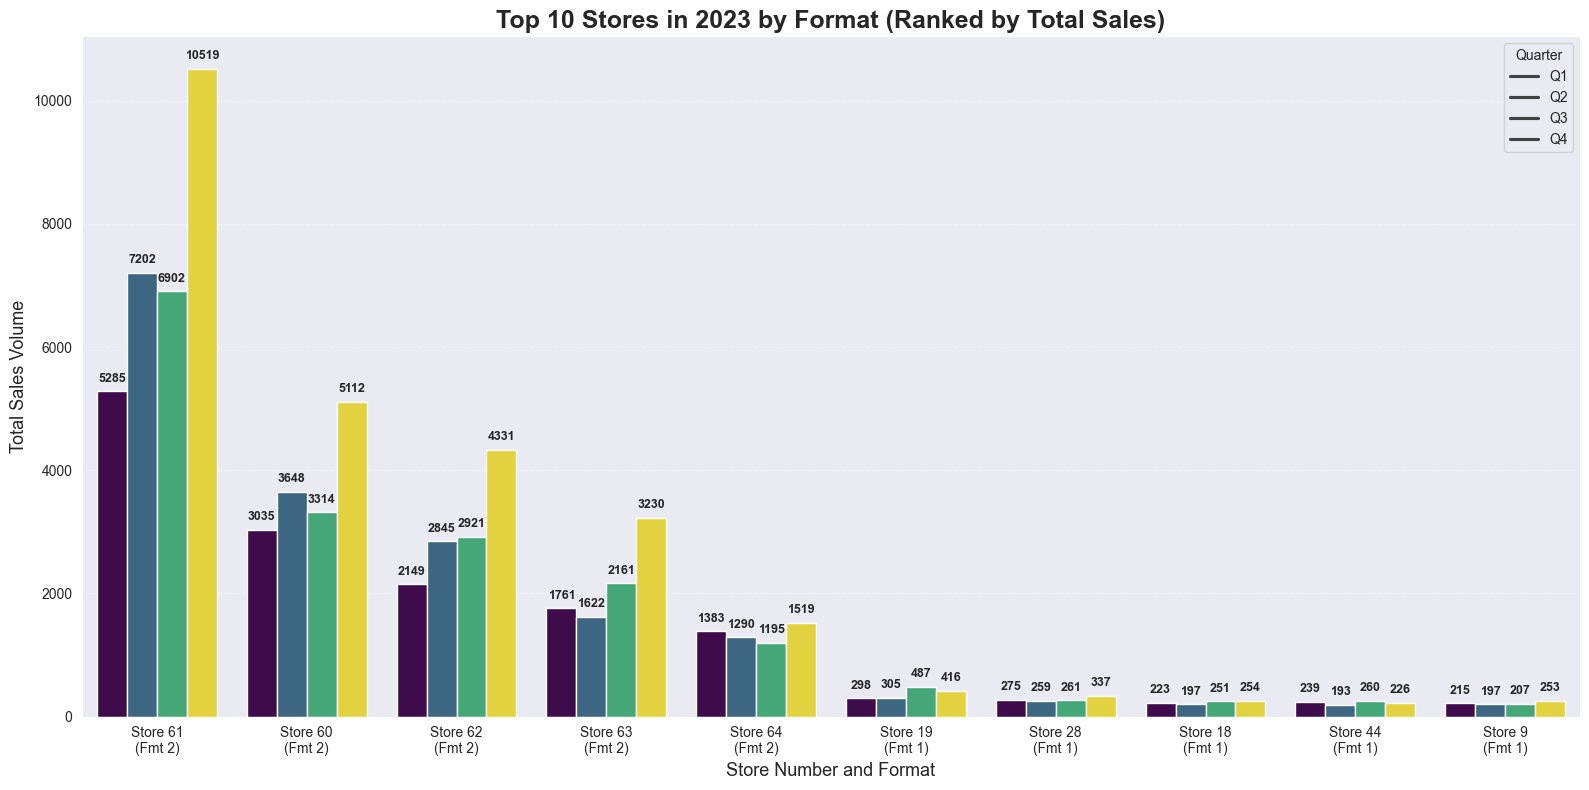

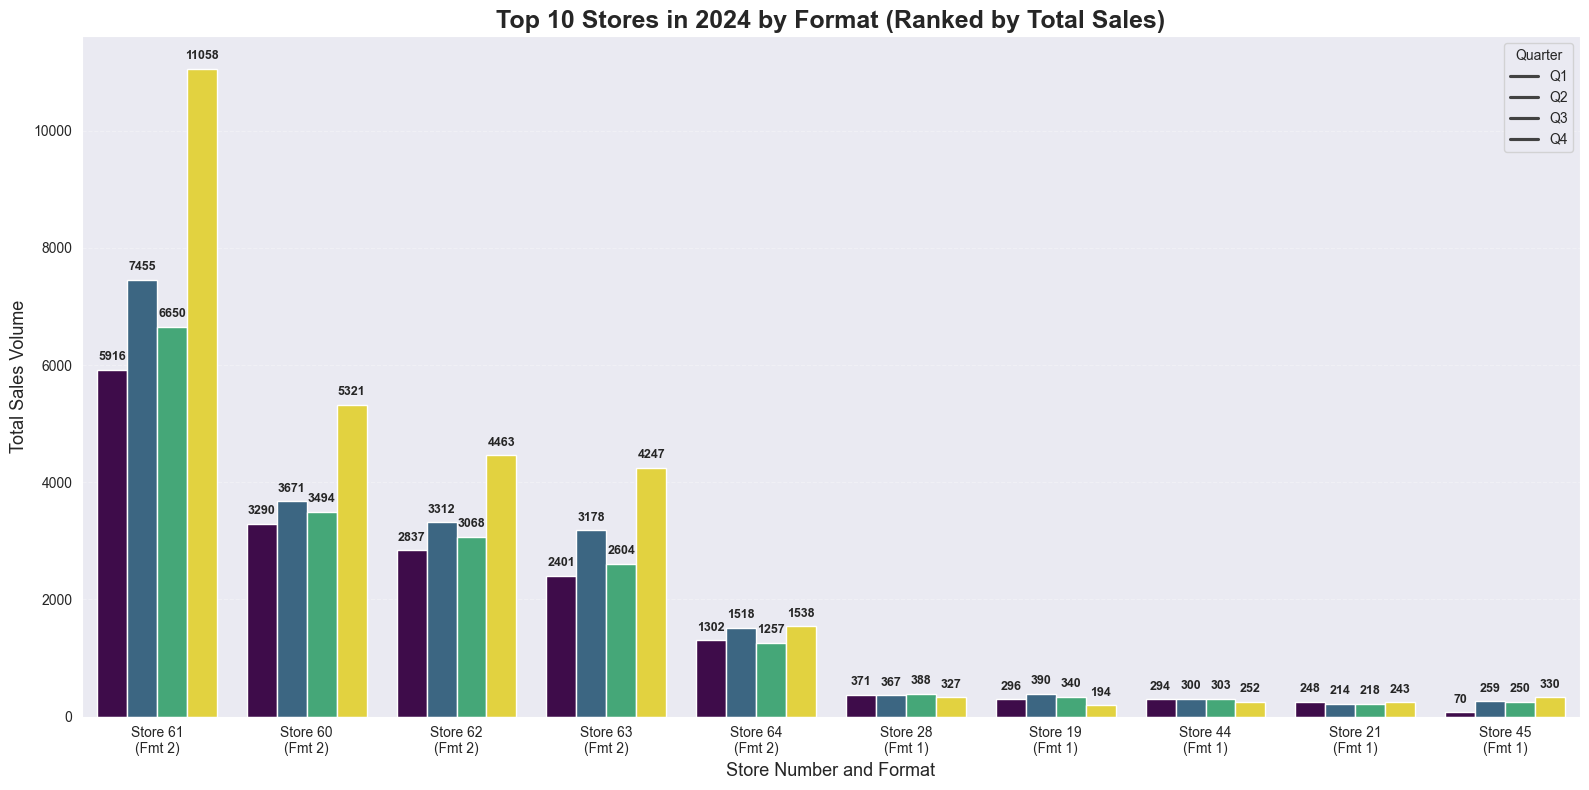

In [10]:
# Ensure time features and mapping exist
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

# Create a unique mapping of store numbers to their formats
store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

# Aggregation
yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

# Iterate through years
years = sorted(yearly_store_stats['year'].unique())

for year in years:
    # Filter for the specific year
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    # Identify top 10 stores for this specific year
    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    # Merge format info and filter for top 10
    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    # Create a combined label for the X-axis: "Store ID (Format)"
    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    # 4. Plotting
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    plt.show()

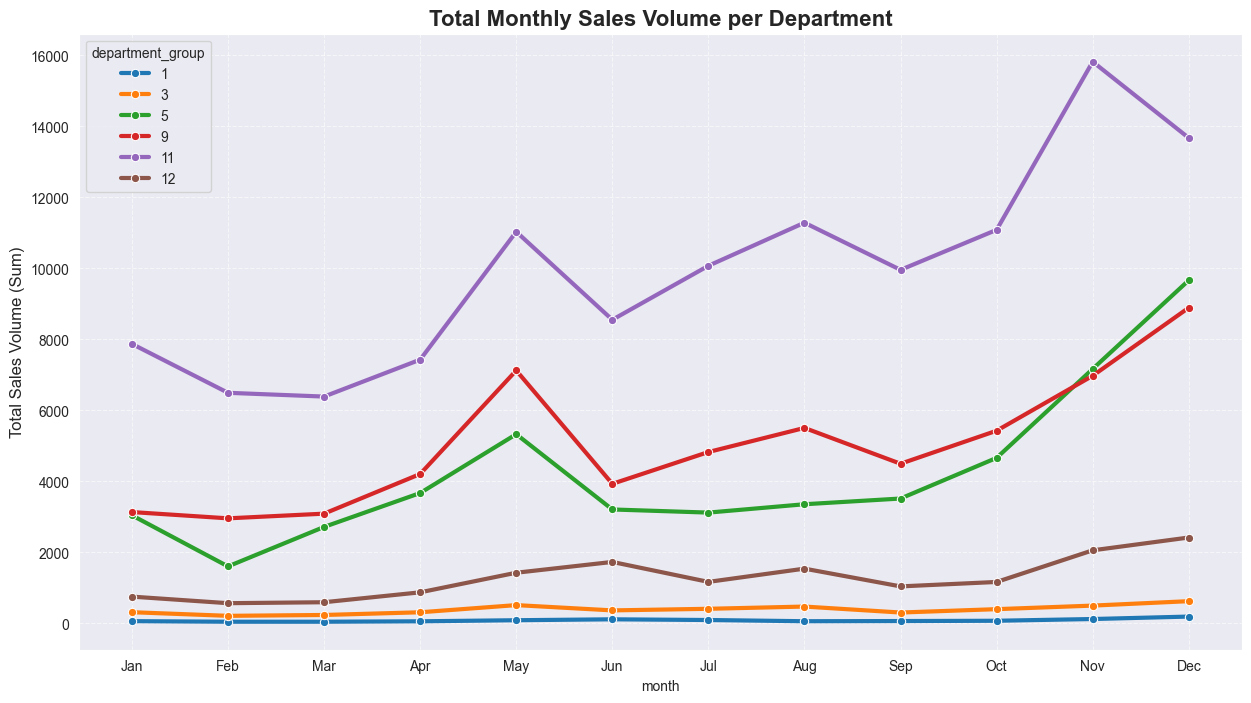

In [11]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

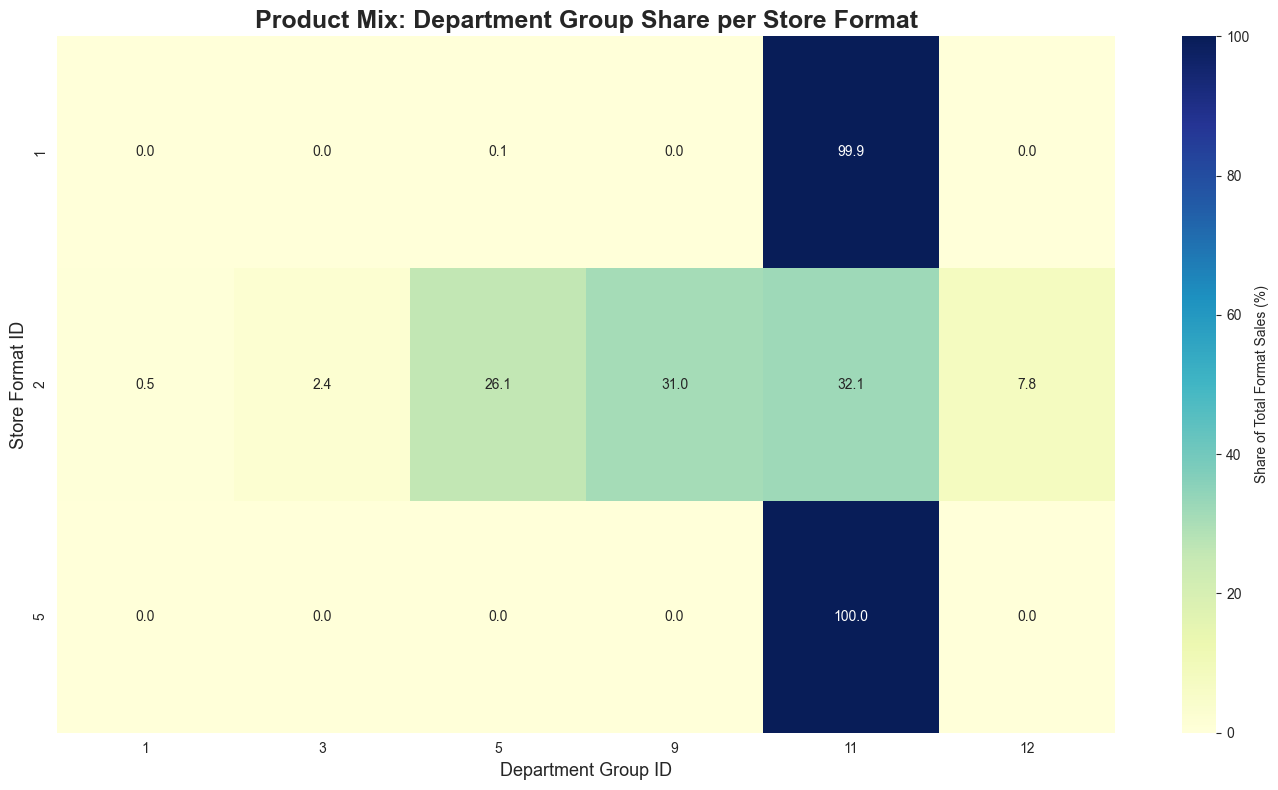

In [12]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.show()

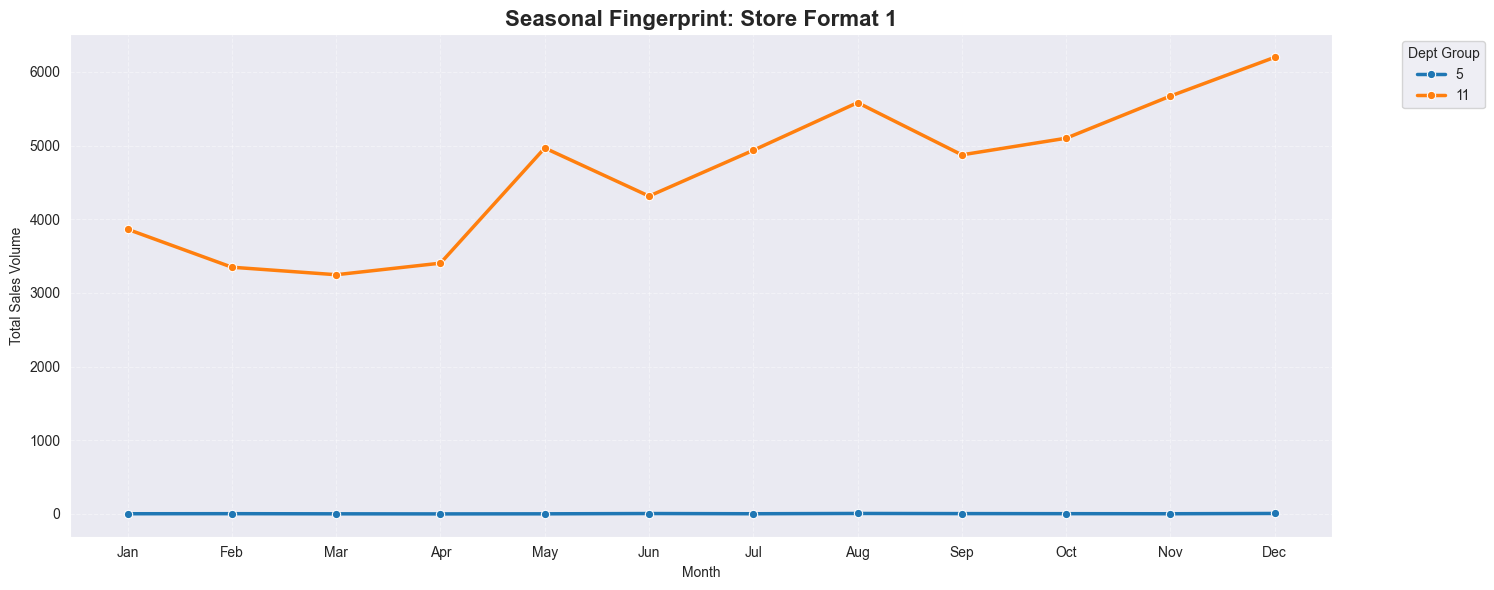

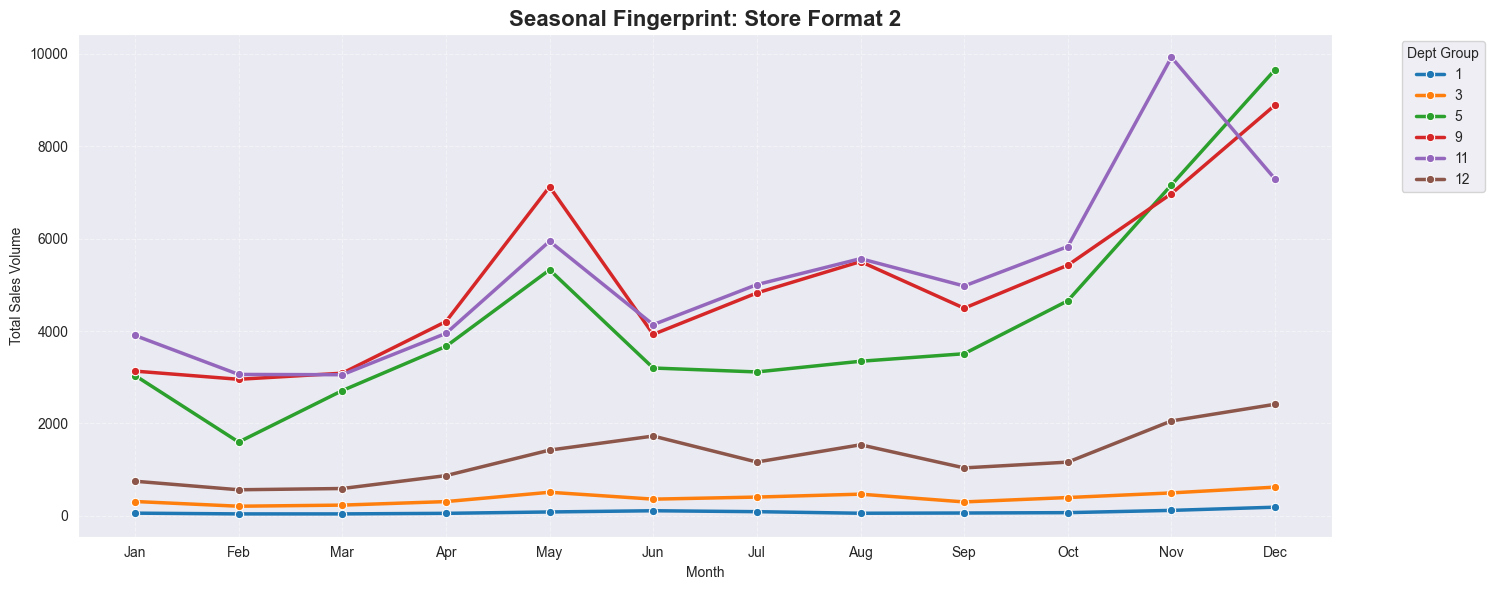

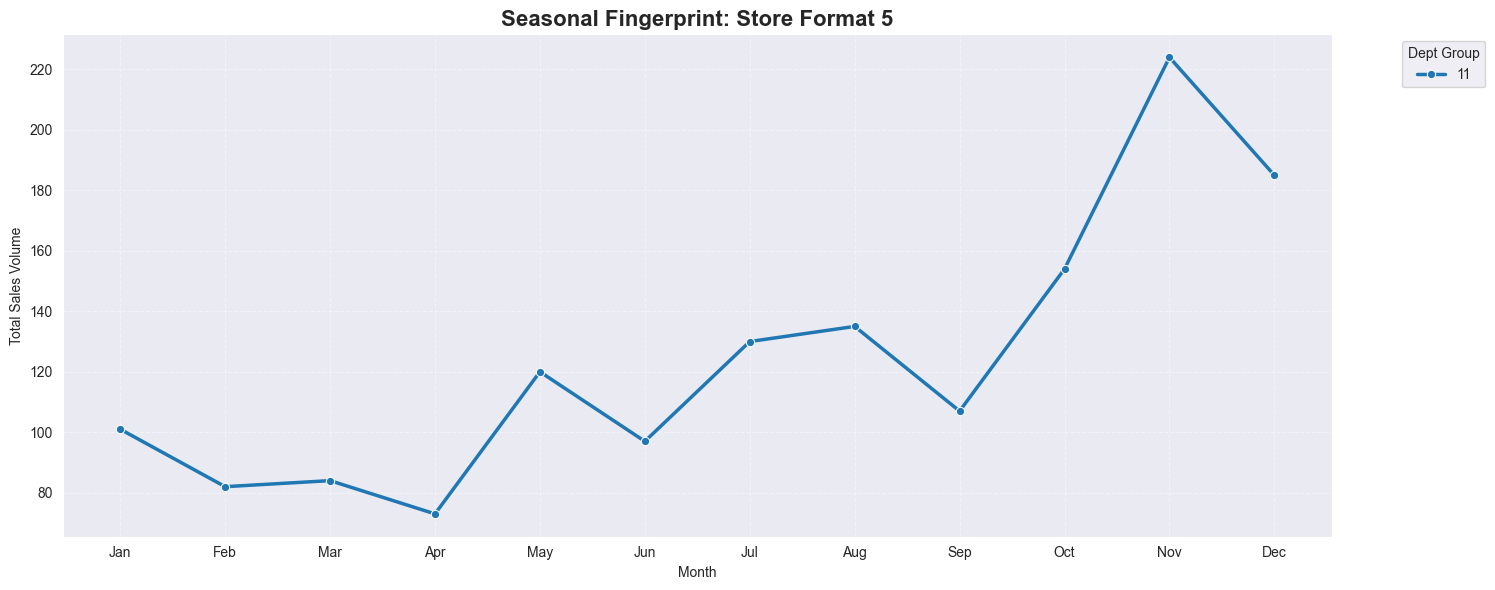

In [13]:
# Identify all unique store formats
unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    # Filter data for the specific format
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]

    # Aggregate sales by department and month for this format
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    # Visualization
    plt.figure(figsize=(15, 6))
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette="tab10"
    )

    plt.title(f'Seasonal Fingerprint: Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume')
    plt.xlabel('Month')
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Preprocessing

In [14]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,format,week,sales,...,rolling_mean_4_wks,rolling_std_4_wks,rolling_mean_12_wks,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,perf_vs_store,yoy_growth
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,...,74276.000000,74276.000000,69484.000000,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,65151.000000,5.391000e+04
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,189.398998,2023-08-18 19:16:03.380281856,2.964413,...,2.850174,1.737603,2.873261,0.956172,2.842173,2.705913,2.965433,0.002152,1.022792,6.902806e+05
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,13.000000,2022-04-12 00:00:00,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000,0.000000e+00
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,216.000000,2022-12-13 00:00:00,0.000000,...,0.500000,0.500000,0.583333,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000,0.000000e+00
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,216.000000,2023-08-18 12:00:00,1.000000,...,1.000000,0.957427,1.083333,0.934171,2.287719,1.266667,1.795745,0.000000,0.253472,6.363636e-01
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,216.000000,2024-04-24 00:00:00,2.000000,...,2.250000,1.732051,2.083333,1.333332,2.946237,2.986395,4.728571,0.405465,0.784053,1.899998e+01
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,521.000000,2024-12-25 00:00:00,494.000000,...,251.250000,203.021345,190.666667,3.000000,26.333333,36.833333,15.558685,4.890349,302.548612,1.110000e+08
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,73.948953,NaN,10.595799,...,8.904223,4.489321,8.546508,0.661086,2.032836,3.611927,2.322635,0.725240,4.468564,2.603973e+06


In [15]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Train-Val-Split for Model Evaluation

In [16]:
date_col = data_loader.get_date_col()
target = data_loader.get_target_col()

max_date = X_train_engineered[date_col].max()
cutoff_date = max_date - pd.Timedelta(weeks=15)

train_mask = X_train_engineered[date_col] <= cutoff_date
val_mask = X_train_engineered[date_col] > cutoff_date

X_train = X_train_engineered.loc[train_mask].drop(columns=[target, "week", "quarter"])
y_train = X_train_engineered.loc[train_mask, target]

X_val = X_train_engineered.loc[val_mask].drop(columns=[target, "week", "quarter"])
y_val = X_train_engineered.loc[val_mask, target]

# Declaration of Categorical Data for the Models
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format', 'format', "week_of_year"
]

print(f"Train set: {X_train.shape[0]} rows | Date range: {X_train_engineered.loc[train_mask, date_col].min().date()} to {cutoff_date.date()}")
print(f"Val set:   {X_val.shape[0]} rows | Date range: {X_train_engineered.loc[val_mask, date_col].min().date()} to {max_date.date()}")

Train set: 76073 rows | Date range: 2022-04-12 to 2024-09-11
Val set:   8985 rows | Date range: 2024-09-18 to 2024-12-25


## Model Training

In [17]:
results = {}

cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=200
)

cat_model.fit(X_train, y_train, 
              cat_features=categorical_features, 
              eval_set=(X_val, y_val),
              early_stopping_rounds=50)

results['CatBoost'] = root_mean_squared_error(y_val, cat_model.predict(X_val))

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42
)

X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
for col in categorical_features:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_val_xgb[col] = X_val_xgb[col].astype('category')

xgb_model.fit(X_train_xgb, y_train, 
              eval_set=[(X_val_xgb, y_val)], 
              verbose=200)

results['XGBoost'] = root_mean_squared_error(y_val, xgb_model.predict(X_val_xgb))

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='regression',
    metric='rmse',
    random_state=42
)

lgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              callbacks=[lgb.early_stopping(50)])

results['LightGBM'] = root_mean_squared_error(y_val, lgb_model.predict(X_val_xgb))

0:	learn: 9.5077767	test: 15.5829529	best: 15.5829529 (0)	total: 72.1ms	remaining: 2m 24s
200:	learn: 4.0750424	test: 7.9290807	best: 7.9242783 (191)	total: 3.23s	remaining: 28.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.776112509
bestIteration = 335

Shrink model to first 336 iterations.
[0]	validation_0-rmse:15.54917
[200]	validation_0-rmse:9.22458
[400]	validation_0-rmse:9.20639
[600]	validation_0-rmse:9.22441
[800]	validation_0-rmse:9.22604
[999]	validation_0-rmse:9.22212
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3771
[

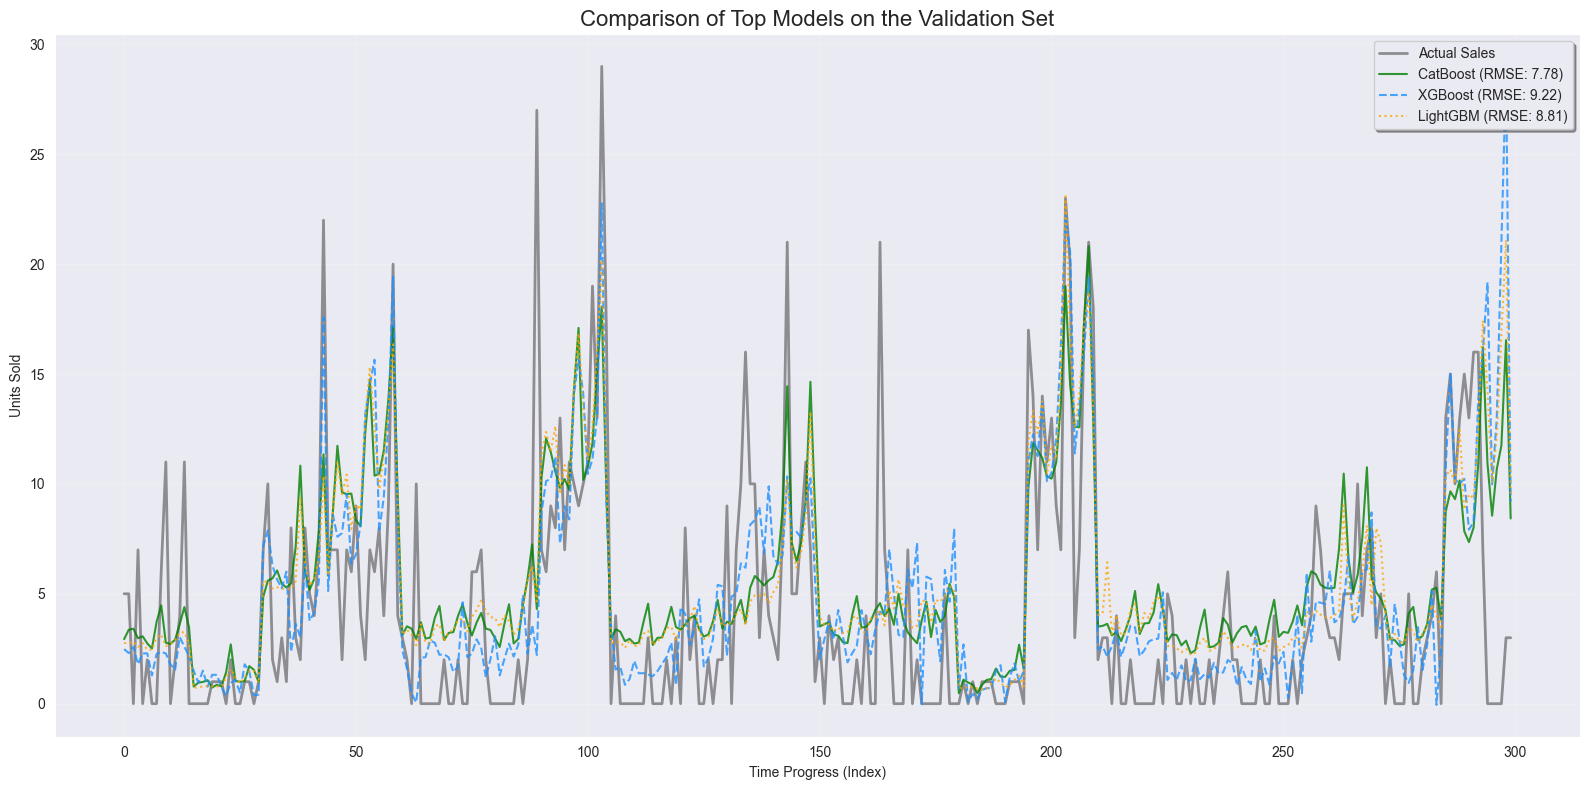

Performance Summary:
              RMSE
CatBoost  7.776113
LightGBM  8.809258
XGBoost   9.222125


In [18]:
# Generate predictions for each model
cat_preds = cat_model.predict(X_val)
xgb_preds = xgb_model.predict(X_val_xgb)
lgb_preds = lgb_model.predict(X_val_xgb)

plt.figure(figsize=(16, 8))

# Limit the plot to the first 300 samples for better visibility
subset = 300 

# Plot the Ground Truth (Actual values)
plt.plot(y_val.values[:subset], label='Actual Sales', 
         color='black', alpha=0.4, linewidth=2)

# Plot CatBoost Predictions
plt.plot(cat_preds[:subset], label=f"CatBoost (RMSE: {results['CatBoost']:.2f})", 
         color='green', linestyle='-', alpha=0.8)

# Plot XGBoost Predictions
plt.plot(xgb_preds[:subset], label=f"XGBoost (RMSE: {results['XGBoost']:.2f})", 
         color='dodgerblue', linestyle='--', alpha=0.8)

# Plot LightGBM Predictions
plt.plot(lgb_preds[:subset], label=f"LightGBM (RMSE: {results['LightGBM']:.2f})", 
         color='orange', linestyle=':', alpha=0.8)

# Chart Styling and Labeling
plt.title("Comparison of Top Models on the Validation Set", fontsize=16)
plt.xlabel("Time Progress (Index)")
plt.ylabel("Units Sold")
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Display performance summary table
print("Performance Summary:")
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
df_results = df_results.sort_values(by='RMSE')
print(df_results)

In [19]:
winner_name = min(results, key=results.get)
print(f"Best Model is: {winner_name} with RMSE: {results[winner_name]}")

Best Model is: CatBoost with RMSE: 7.776112509258527


In [20]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 10)
    
    if winner_name == 'XGBoost':
        param = {
            'learning_rate': learning_rate,
            'max_depth': depth,
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'n_estimators': 2000,
            'random_state': 42,
            'enable_categorical': True,
            'early_stopping_rounds': 50,
            'tree_method': 'hist',
            'verbosity': 0
        }
        
        # XGBoost Pruning Callback
        pruning_callback = XGBoostPruningCallback(trial, 'validation_0-rmse')
        
        model = xgb.XGBRegressor(**param)
        model.fit(
            X_train_xgb, y_train, 
            eval_set=[(X_val_xgb, y_val)], 
            callbacks=[pruning_callback],
            verbose=False
        )
        
        trial.set_user_attr("best_ntree", model.best_iteration)
        preds = model.predict(X_val_xgb)

    elif winner_name == 'CatBoost':
        param = {
            'learning_rate': learning_rate,
            'depth': depth,
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'iterations': 2000,
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50,
            'bootstrap_type': 'Bernoulli', 
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'used_ram_limit': '10gb'
        }
        
        # CatBoost Pruning Callback
        pruning_callback = CatBoostPruningCallback(trial, 'RMSE')
        
        model = CatBoostRegressor(**param)
        model.fit(
            X_train, y_train, 
            cat_features=categorical_features, 
            eval_set=(X_val, y_val),
            callbacks=[pruning_callback]
        )
        
        trial.set_user_attr("best_ntree", model.tree_count_)
        preds = model.predict(X_val)

    elif winner_name == 'LightGBM':
        param = {
            'learning_rate': learning_rate,
            'max_depth': depth,
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'n_estimators': 2000,
            'random_state': 42,
            'verbose': -1,
            'metric': 'rmse'
        }
        
        # LightGBM Pruning Callback
        pruning_callback = LightGBMPruningCallback(trial, 'rmse')
        
        model = lgb.LGBMRegressor(**param)
        model.fit(
            X_train_xgb, y_train, 
            eval_set=[(X_val_xgb, y_val)], 
            callbacks=[
                lgb.early_stopping(50),
                pruning_callback
            ]
        )
        
        trial.set_user_attr("best_ntree", model.best_iteration_)
        preds = model.predict(X_val_xgb)

    return root_mean_squared_error(y_val, preds)

# Optuna Study Start
study = optuna.create_study(
    direction='minimize', 
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

study.optimize(objective, n_trials=50)

[I 2025-12-22 21:16:07,706] A new study created in memory with name: no-name-2a4778b8-9d56-447b-8bed-2e228d893ccc
/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_33377/3249708193.py:49: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'RMSE')
[I 2025-12-22 21:16:51,846] Trial 0 finished with value: 8.356469559387463 and parameters: {'learning_rate': 0.016796011191440995, 'max_depth': 10, 'l2_leaf_reg': 8.722851933809723, 'subsample': 0.9149371934866031}. Best is trial 0 with value: 8.356469559387463.
/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_33377/3249708193.py:49: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'RMSE')
[I 2025-12-22 21:17:04,748] Trial 1 finished with value: 7.881238391143691 and parame

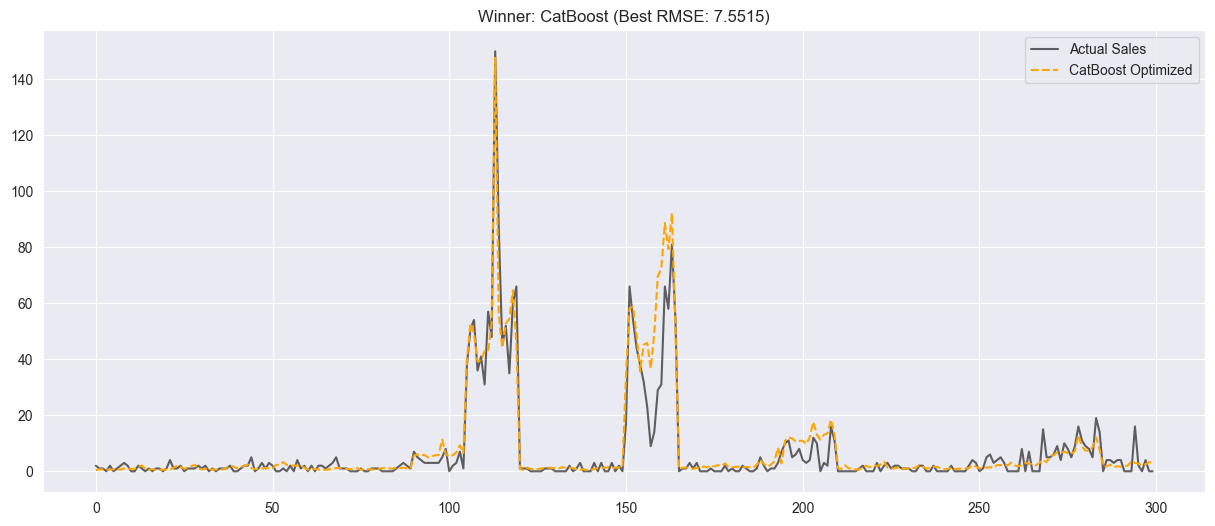

In [21]:
X_final_train_data = pd.concat([X_train_xgb, X_val_xgb]) if winner_name != 'CatBoost' else pd.concat([X_train, X_val])
y_final_train_data = pd.concat([y_train, y_val])

if winner_name != 'CatBoost':
    for col in categorical_features:
        X_final_train_data[col] = X_final_train_data[col].astype('category')
        
        #test_input[col] = test_input[col].astype('category')
        #test_input[col] = test_input[col].cat.set_categories(X_final_train_data[col].cat.categories)
        
best_ntree = study.best_trial.user_attrs["best_ntree"]

if winner_name == 'XGBoost':
    final_model = xgb.XGBRegressor(**study.best_params, n_estimators=best_ntree, enable_categorical=True, random_state=42)
elif winner_name == 'CatBoost':
    final_model = CatBoostRegressor(**study.best_params, iterations=best_ntree, random_seed=42, verbose=False)
elif winner_name == 'LightGBM':
    final_model = lgb.LGBMRegressor(**study.best_params, n_estimators=best_ntree, random_state=42)

final_model.fit(X_final_train_data, y_final_train_data)

test_input = X_val_xgb if winner_name != 'CatBoost' else X_val
val_preds = final_model.predict(test_input)

plt.figure(figsize=(15, 6))
plt.plot(y_val.values[-300:], label='Actual Sales', color='black', alpha=0.6)
plt.plot(val_preds[-300:], label=f'{winner_name} Optimized', color='orange', linestyle='--')
plt.title(f"Winner: {winner_name} (Best RMSE: {study.best_value:.4f})")
plt.legend()
plt.show()

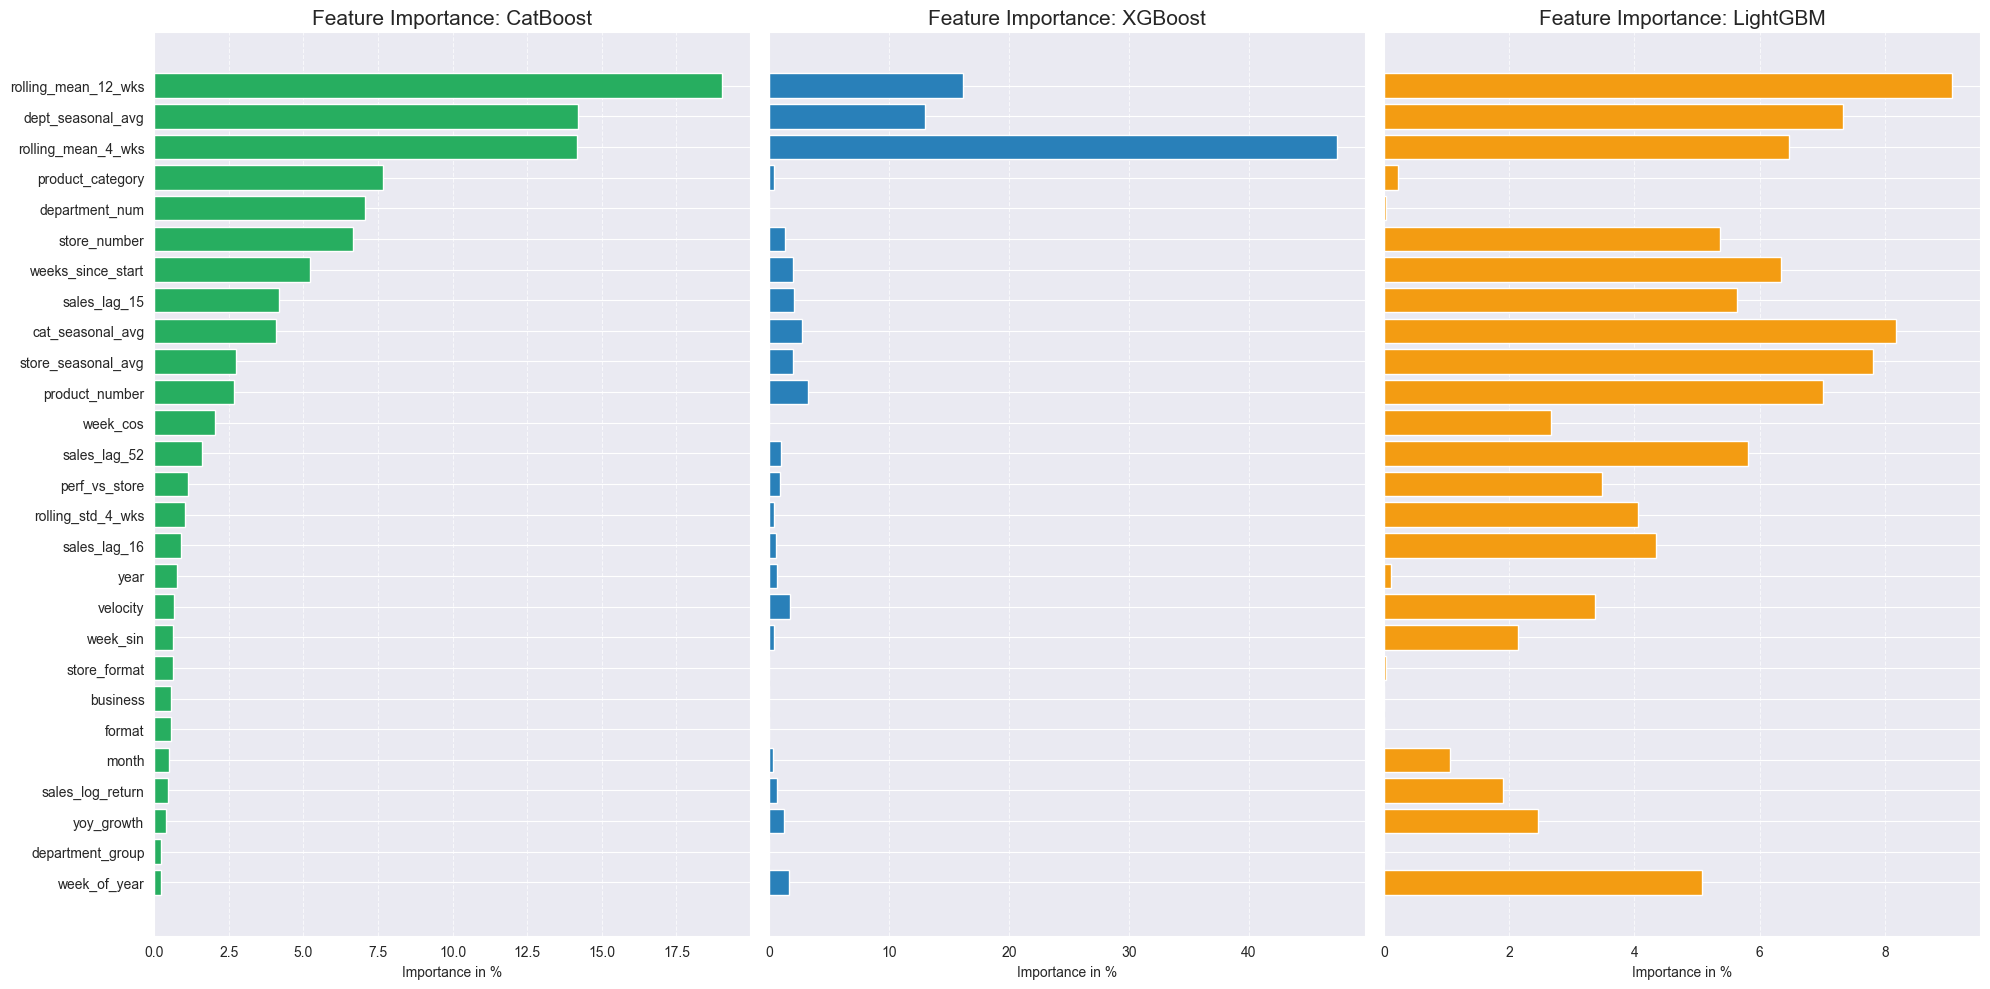

In [22]:
feature_names = X_train_xgb.columns

cat_importances = cat_model.get_feature_importance()
xgb_importances = xgb_model.feature_importances_
lgb_importances = lgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'CatBoost': cat_importances,
    'XGBoost': xgb_importances,
    'LightGBM': lgb_importances
})

for col in ['CatBoost', 'XGBoost', 'LightGBM']:
    importance_df[col] = (importance_df[col] / importance_df[col].sum()) * 100

importance_df['Average'] = importance_df[['CatBoost', 'XGBoost', 'LightGBM']].mean(axis=1)
importance_df = importance_df.sort_values(by='Average', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

models = ['CatBoost', 'XGBoost', 'LightGBM']
colors = ['#27ae60', '#2980b9', '#f39c12']

for i, model in enumerate(models):
    df_sorted = importance_df.sort_values(by=model, ascending=True)
    
    axes[i].barh(df_sorted['Feature'], df_sorted[model], color=colors[i])
    axes[i].set_title(f'Feature Importance: {model}', fontsize=15)
    axes[i].set_xlabel('Importance in %')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Test Data

In [23]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_final_train_data.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if winner_name != 'CatBoost':
    for col in categorical_features:
        # Cast to category
        X_test_predict[col] = X_test_predict[col].astype('category')
        # Ensure the test set has the EXACT same category mapping as the train set
        X_test_predict[col] = X_test_predict[col].cat.set_categories(X_final_train_data[col].cat.categories)

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'week']].copy()
df_results['predicted_sales'] = test_predictions

output_path = f'final_sales_predictions_{winner_name}.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

Predictions saved to final_sales_predictions_CatBoost.xlsx
     store_number  product_number       week  predicted_sales
142             0             126 2025-01-01         2.899581
143             0             126 2025-01-08         1.545035
144             0             126 2025-01-15         1.919429
145             0             126 2025-01-22         2.453832
146             0             126 2025-01-29         2.282513


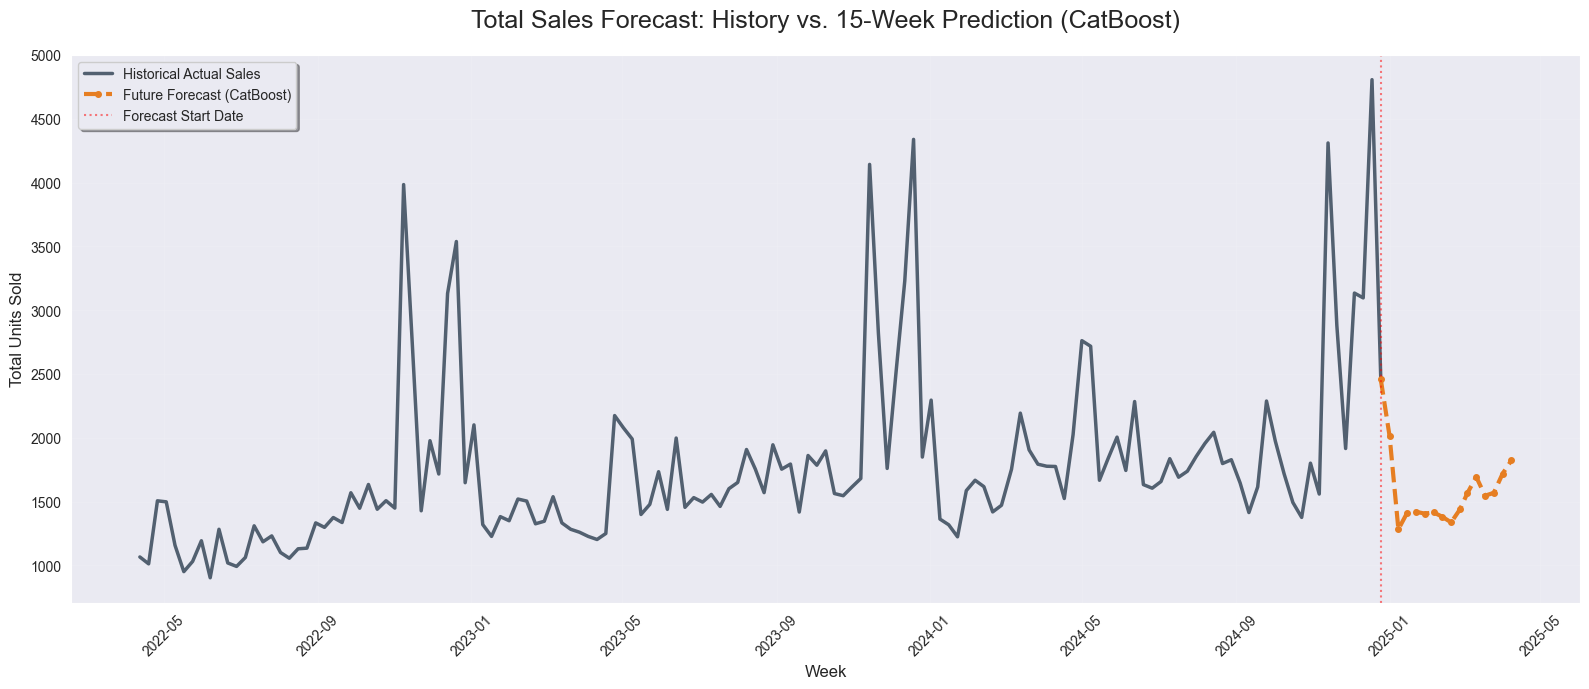

In [24]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_final_train_data.index],
    'sales': y_final_train_data
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['predicted_sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1).rename(columns={'sales': 'predicted_sales'})

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(16, 7))

# Plot Historical Sales (The "Past")
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#2c3e50', linewidth=2.5, alpha=0.8)

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['predicted_sales'],
         label=f'Future Forecast ({winner_name})', color='#e67e22',
         linestyle='--', linewidth=3, marker='o', markersize=4)

# Split Line (Vertical line at "Today")
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({winner_name})", fontsize=18, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='-', alpha=0.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sales_forecast_connected.png')
plt.show()

In [25]:
df_results_preprocessed = data_loader.preprocessing(df_results.rename(columns={'predicted_sales': 'sales'}))
df_results_preprocessed

,store_number,product_number,week,sales,month,week_of_year,year
0,0,126,2025-01-01,2.899581,1,1,2025
1,0,126,2025-01-08,1.545035,1,2,2025
2,0,126,2025-01-15,1.919429,1,3,2025
3,0,126,2025-01-22,2.453832,1,4,2025
4,0,126,2025-01-29,2.282513,1,5,2025
...,...,...,...,...,...,...,...
8980,66,126,2025-03-11,2.622480,3,11,2025
8981,66,126,2025-03-18,2.337883,3,12,2025
8982,66,126,2025-03-25,2.624048,3,13,2025
8983,66,126,2025-04-01,2.101909,4,14,2025


## Trends in Forecast Data

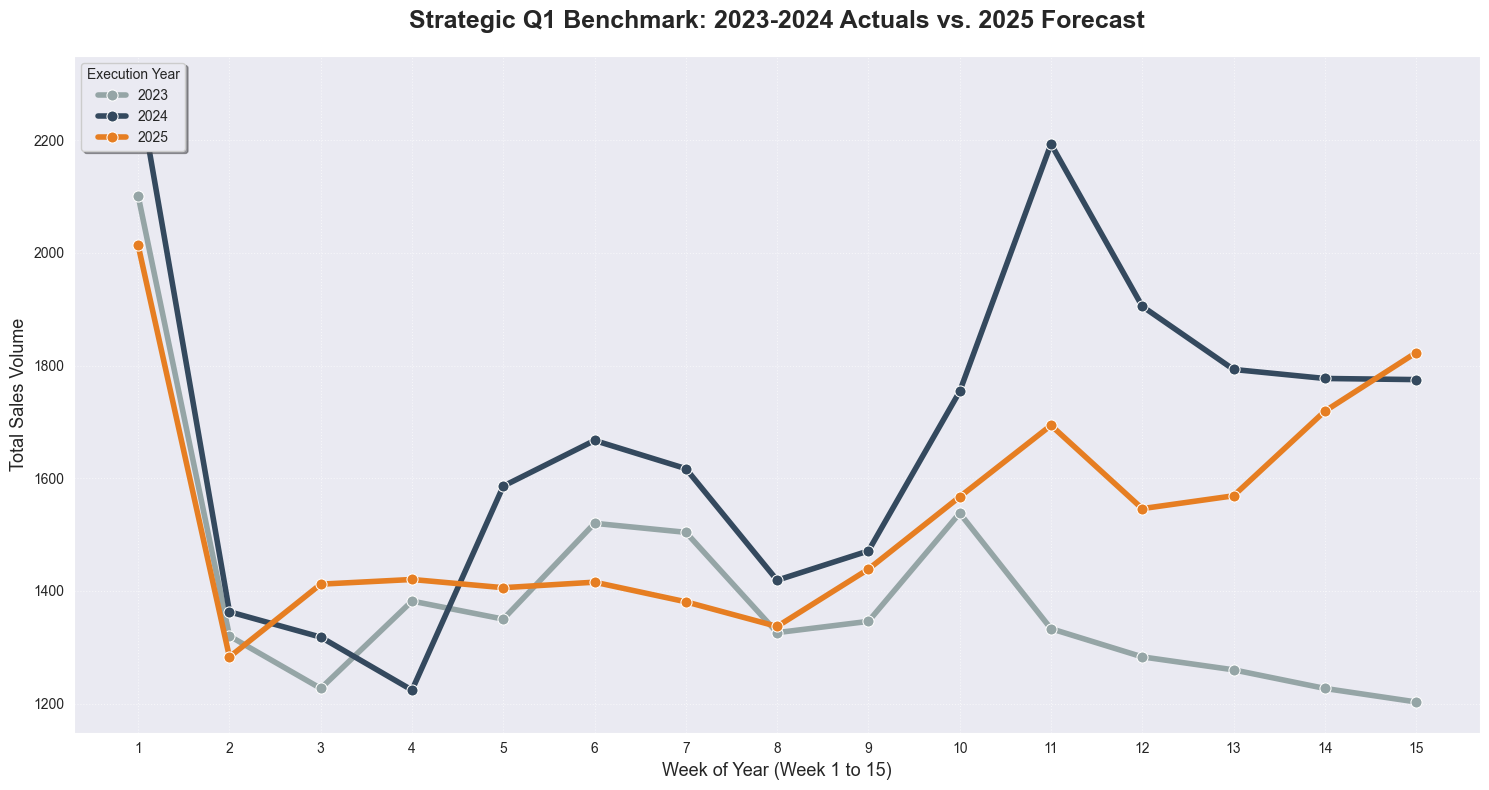

In [26]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('Strategic Q1 Benchmark: 2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

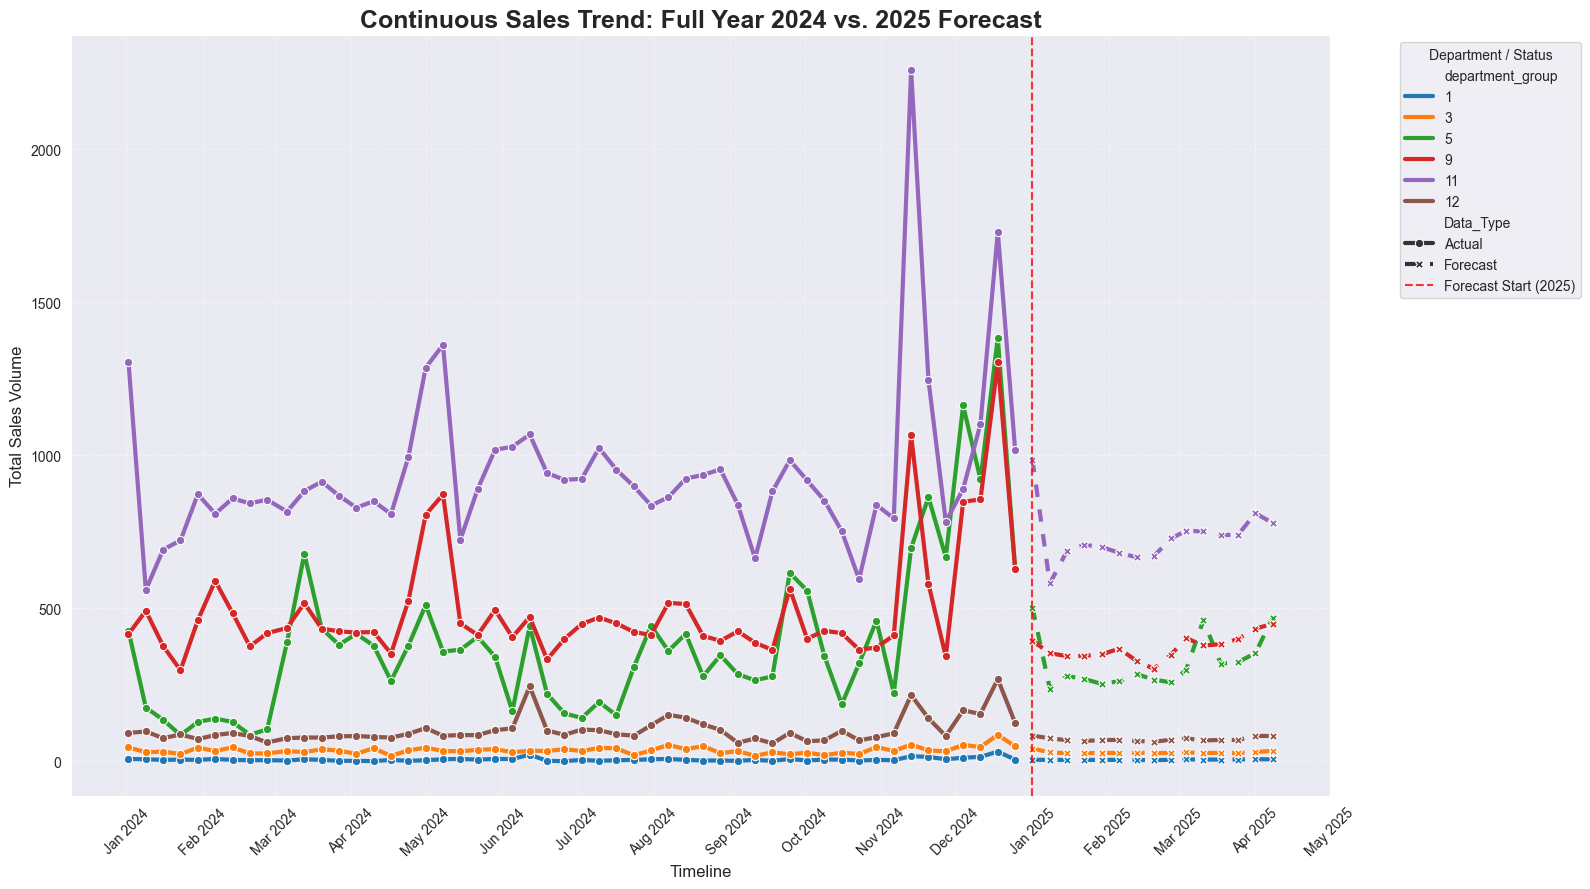

In [27]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(16, 9))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()